In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import bioframe

import cooler
import cooltools 
import cooltools.expected

In [2]:
import cooltools.sandbox
import cooltools.sandbox.expected_smoothing

In [3]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [4]:
# Load a Hi-C map at a 1kb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/1000')

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.core.construction.add_ucsc_name_column(bioframe.make_chromarms(hg38_chromsizes,  hg38_cens))

hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2:0-93139351
1,chr2,93139351,242193529,chr2:93139351-242193529
2,chr17,0,24714921,chr17:0-24714921
3,chr17,24714921,83257441,chr17:24714921-83257441


In [6]:
# cvd == contacts-vs-distance
cvd = cooltools.expected.diagsum(
    clr=clr,
    view_df=hg38_arms,
    transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
)

In [7]:
cvd

,region,diag,n_valid,count.sum,balanced.sum
0,chr2:0-93139351,0,86055,NaN,NaN
1,chr2:0-93139351,1,85282,NaN,NaN
2,chr2:0-93139351,2,84918,10859113.0,8344.916674
3,chr2:0-93139351,3,84649,4742194.0,3623.417357
4,chr2:0-93139351,4,84442,2664596.0,2027.610660
...,...,...,...,...,...
325449,chr17:24714921-83257441,58539,0,0.0,0.000000
325450,chr17:24714921-83257441,58540,0,0.0,0.000000
325451,chr17:24714921-83257441,58541,0,0.0,0.000000
325452,chr17:24714921-83257441,58542,0,0.0,0.000000


In [8]:
# import importlib
# importlib.reload(cooltools.sandbox.expected_smoothing)

In [9]:
cvd_smoothed = cooltools.sandbox.expected_smoothing.smooth_cvd(cvd, groupby=['region'], agg=False)

In [10]:
cvd_smoothed

,region,diag,n_valid,count.sum,balanced.sum,balanced.avg,n_valid.smoothed,balanced.sum.smoothed,balanced.avg.smoothed
0,chr2:0-93139351,0,86055,NaN,NaN,NaN,0.000000e+00,0.000000,NaN
1,chr2:0-93139351,1,85282,NaN,NaN,NaN,8.619757e+04,NaN,NaN
2,chr2:0-93139351,2,84918,10859113.0,8344.916674,0.098270,1.047369e+05,NaN,NaN
3,chr2:0-93139351,3,84649,4742194.0,3623.417357,0.042805,1.495651e+05,NaN,NaN
4,chr2:0-93139351,4,84442,2664596.0,2027.610660,0.024012,2.002158e+05,4871.588615,2.433169e-02
...,...,...,...,...,...,...,...,...,...
325449,chr17:24714921-83257441,58539,0,0.0,0.000000,NaN,8.532259e+07,40.128635,4.703167e-07
325450,chr17:24714921-83257441,58540,0,0.0,0.000000,NaN,8.531510e+07,40.124875,4.703139e-07
325451,chr17:24714921-83257441,58541,0,0.0,0.000000,NaN,8.530762e+07,40.121115,4.703110e-07
325452,chr17:24714921-83257441,58542,0,0.0,0.000000,NaN,8.530014e+07,40.117355,4.703082e-07


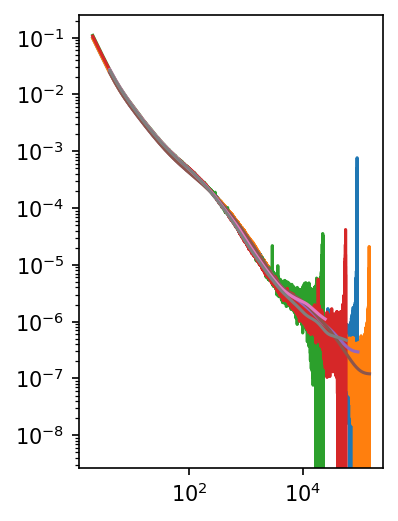

In [11]:
plt.rcParams['figure.dpi'] = 150

for reg in cvd.region.unique():
    cvd_loc = cvd[cvd.region == reg]
    plt.loglog(
        cvd_loc['diag'],
        cvd_loc['balanced.sum'] / cvd_loc['n_valid']
    )

for reg in cvd_smoothed.region.unique():
    cvd_loc = cvd_smoothed[cvd_smoothed.region == reg]

    plt.loglog(
        cvd_loc['diag'],
        cvd_loc['balanced.avg.smoothed']
    )
ax = plt.gca()
ax.set(aspect=1.0);

In [12]:
# Genome-wide P(s):
cvd_smoothed_gw = cooltools.sandbox.expected_smoothing.smooth_cvd(cvd, groupby=None, agg=True)

/users/anton.goloborodko/src/cooltools/cooltools/sandbox/expected_smoothing.py:36: RuntimeWarning: divide by zero encountered in log
  np.log(xs),
/users/anton.goloborodko/src/cooltools/cooltools/sandbox/expected_smoothing.py:37: RuntimeWarning: divide by zero encountered in log
  np.log(xp),
/users/anton.goloborodko/src/cooltools/cooltools/sandbox/expected_smoothing.py:38: RuntimeWarning: divide by zero encountered in log
  np.log(fp),


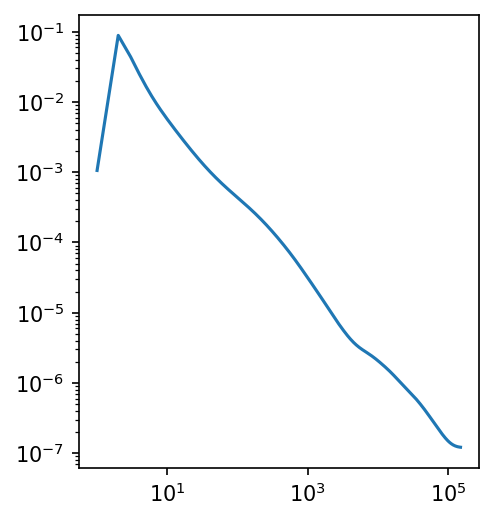

In [13]:
plt.loglog(
    cvd_smoothed_gw['diag'],
    cvd_smoothed_gw['balanced.avg.smoothed'],
)
ax = plt.gca()
ax.set(aspect=1.0);